# 0. Basics

## 0.0. Imports

In [1]:
import os
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
from datetime import datetime as DT

In [2]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM

In [3]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'G:\\code\\WS_Mdl\\utils_imod.py'>

In [4]:
# Import sfrmaker and other necessary packages for SFR network creation
import sfrmaker as sfr
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiLineString, box

In [5]:
import imod

In [6]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

## 0.1. Options

In [7]:
MdlN = 'NBr44'

In [8]:
U.set_verbose(False)

In [9]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

# 1. Read in list of RIV cells

## 1.0. Read in

In [10]:
d_Pa.keys()

dict_keys(['imod_V', 'Mdl', 'MdlN', 'Pa_Mdl', 'Smk_temp', 'In', 'PoP', 'code', 'pixi', 'coupler_Exe', 'MF6_DLL', 'MSW_DLL', 'INI', 'BAT', 'PRJ', 'Smk', 'Sim', 'Pa_MdlN', 'MF6', 'MSW', 'TOML', 'TOML_iMOD5', 'LST_Sim', 'LST_Mdl', 'NAM_Sim', 'NAM_Mdl', 'Sim_In', 'Sim_Out', 'SFR', 'Out_HD', 'Out_HD_Bin', 'DIS_GRB', 'PoP_Out_MdlN', 'MM'])

In [11]:
Pa_RIV = PJ(d_Pa['Sim_In'], 'rivriv/riv-0.bin')
Pa_RIV

'G:/models/NBr\\Sim/NBr44\\modflow6/imported_model\\rivriv/riv-0.bin'

In [12]:
help(imod.formats.gen.read)

Help on function read in module imod.formats.gen.gen:

read(path)
    Read a GEN file to a geopandas GeoDataFrame. The function first tries to
    read as binary, if this fails, it tries to read the gen file as ASCII.

    If certain that a GEN file is ascii or binary, the user is adviced to use
    the respective functions :func:`imod.gen.gen.read_ascii` or
    :func:`imod.gen.gen.read_binary`.

    Parameters
    ----------
    path: Union[str, Path]

    Returns
    -------
    geodataframe: gpd.GeoDataFrame



In [13]:
from pathlib import Path

def read_mf6_riv_bin(filepath: str | Path) -> pd.DataFrame:
    """Read MODFLOW 6 RIV binary input (imod format) into a DataFrame."""
    dtype = np.dtype([
        ("k",    "<i4"),   # layer
        ("i",    "<i4"),   # row
        ("j",    "<i4"),   # column
        ("stage","<f8"),   # stage
        ("cond", "<f8"),   # conductance
        ("rbot", "<f8"),   # river bottom
    ])
    path = Path(filepath)
    nrec = path.stat().st_size // dtype.itemsize
    arr = np.fromfile(path, dtype=dtype, count=nrec)
    return pd.DataFrame(arr)

DF_RIV = read_mf6_riv_bin(Pa_RIV)
DF_RIV.head()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [14]:
# Diagnostic: Check file size and potential formats
path_riv = Path(Pa_RIV)
file_size = path_riv.stat().st_size
record_size_f8 = 36 # 3 ints (4 bytes) + 3 floats (8 bytes)
n_records_f8 = file_size // record_size_f8
remainder_f8 = file_size % record_size_f8

print(f"File size: {file_size} bytes")
print(f"Records (Double Precision, 36B): {n_records_f8}, Remainder: {remainder_f8}")

# Check single precision
record_size_f4 = 24 # 3 ints (4 bytes) + 3 floats (4 bytes)
n_records_f4 = file_size // record_size_f4
remainder_f4 = file_size % record_size_f4
print(f"Records (Single Precision, 24B): {n_records_f4}, Remainder: {remainder_f4}")

# Check for other riv files
print(f"\nOther .bin files in {path_riv.parent}:")
for p in path_riv.parent.glob("*.bin"):
    print(p.name)

if remainder_f4 == 0 and n_records_f4 > n_records_f8:
    print("\nSingle precision seems likely (0 remainder and more rows).")
    
    def read_mf6_riv_bin_f4(filepath: str | Path) -> pd.DataFrame:
        """Read MODFLOW 6 RIV binary input (single precision) into a DataFrame."""
        dtype = np.dtype([
            ("k",    "<i4"),
            ("i",    "<i4"),
            ("j",    "<i4"),
            ("stage","<f4"),
            ("cond", "<f4"),
            ("rbot", "<f4"),
        ])
        path = Path(filepath)
        nrec = path.stat().st_size // dtype.itemsize
        arr = np.fromfile(path, dtype=dtype, count=nrec)
        return pd.DataFrame(arr)

    DF_RIV = read_mf6_riv_bin_f4(Pa_RIV)
    print("Reloaded DF_RIV with single precision.")
    print(DF_RIV.head())
    print(DF_RIV.shape)

File size: 51660 bytes
Records (Double Precision, 36B): 1435, Remainder: 0
Records (Single Precision, 24B): 2152, Remainder: 12

Other .bin files in G:\models\NBr\Sim\NBr44\modflow6\imported_model\rivriv:
riv-0.bin


## 1.1. Explore & edit.

In [15]:
DF_RIV

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [16]:
DF_RIV.loc[ ( DF_RIV['stage'] - DF_RIV['rbot'] ) > 0.01].empty

True

Elv is just Elv2 rounded to the 2nd decimal.

In [17]:
DF_RIV

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [18]:
DF_RIV.rename(columns={'k':'L', 'i':'R', 'j':'C'}, inplace=True)

In [19]:
DF_RIV_ = DF_RIV.copy()  # Copy to avoid modifying original DF_DRN.
DF_RIV_ = DF_RIV_.drop(
    columns=[i for i in DF_RIV_.columns if i not in ['L', 'R', 'C']]
)  # We only need L, R, C for matching.

In [20]:
DF_RIV_.index += 1  # Make it 1-based index, as in MODFLOW.

In [21]:
DF_RIV_ = DF_RIV_.reset_index().rename(columns={'index': 'Pvd_i'})

In [22]:
DF_RIV_.tail()

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


## 1.2. L R C to X Y

In [23]:
# Add X and Y coordinates to RIV dataframe and create geometry
DF_RIV_['X'] = Xmin + DF_RIV_['C'] * dx - dx / 2
DF_RIV_['Y'] = Ymax - DF_RIV_['R'] * dy + dy / 2


## 1.3. Load Chaamse Beek shapefile and limit DFs to it's extent

In [24]:
Pa_CB = PJ(U.Pa_WS, r'models\NBr\PoP\common\Pgn\Chaamse_beek\catchment_chaamsebeek_ulvenhout.shp') # CB: Chaamse Beek
GDF_CB = gpd.read_file(Pa_CB)
print(f"Loaded shapefile with {len(GDF_CB)} features")
print(f"CRS: {GDF_CB.crs}")
print(f"Bounds: {GDF_CB.bounds}")

g:\.pixi\envs\default\Lib\site-packages\pyogrio\__init__.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos  # noqa: F401


Loaded shapefile with 1 features
CRS: None
Bounds:           minx         miny         maxx         maxy
0  113434.7999  387938.1329  124760.5671  395868.0663


In [25]:
from shapely.geometry import Point

In [26]:
# Create geometry for RIV points
DF_RIV_['geometry'] = DF_RIV_.apply(lambda row: Point(row['X'], row['Y']), axis=1)
GDF_RIV = gpd.GeoDataFrame(DF_RIV_, crs=GDF_CB.crs)

print(f"Created GeoDataFrame for RIV with {len(GDF_RIV)} points")
print(f"RIV points bounds: minX={GDF_RIV.bounds['minx'].min():.2f}, minY={GDF_RIV.bounds['miny'].min():.2f}, maxX={GDF_RIV.bounds['maxx'].max():.2f}, maxY={GDF_RIV.bounds['maxy'].max():.2f}")

Created GeoDataFrame for RIV with 1435 points
RIV points bounds: minX=113162.50, minY=387612.50, maxX=124737.50, maxY=396187.50


In [27]:
# Store original counts before filtering
original_riv_count = len(GDF_RIV)

# Perform spatial intersection to limit points to catchment extent
GDF_RIV_in = gpd.sjoin(GDF_RIV, GDF_CB, how='inner', predicate='within')

print(f"RIV points within catchment: {len(GDF_RIV_in)} out of {original_riv_count} ({len(GDF_RIV_in)/original_riv_count*100:.1f}%)")

RIV points within catchment: 864 out of 1435 (60.2%)


In [28]:
# Update the original dataframes with only the points within the catchment
# Remove the extra columns from the spatial join (keep only original columns)
original_drn_cols = ['Pvd_i', 'L', 'R', 'C', 'X', 'Y']
original_riv_cols = ['Pvd_i', 'L', 'R', 'C', 'X', 'Y']

DF_RIV_in = GDF_RIV_in[original_riv_cols].copy()

print(f"Final limited dataframes:")
print(f"DF_RIV_in: {len(DF_RIV_in)} points, out of original {len(DF_RIV_)} points -> {len(DF_RIV_in)/len(DF_RIV_)*100:.1f}%")

Final limited dataframes:
DF_RIV_in: 864 points, out of original 1435 points -> 60.2%


# 2. Build OBS files.

## 2.0. General

In [29]:
Dir_RIV_OBS = PJ(d_Pa['Pa_Mdl'], f'In/OBS/RIV/{MdlN}')
os.makedirs(Dir_RIV_OBS, exist_ok=True)

In [30]:
Pa_RIV_OBS = PJ(Dir_RIV_OBS, f'{MdlN}.RIV.OBS6')


In [31]:
Opt = """BEGIN OPTIONS
	DIGITS 4
	PRINT_INPUT
END OPTIONS\n
"""

## 2.1. RIV OBS

In [32]:
DF_RIV_w = pd.DataFrame()
DF_RIV_w['obsname'] = DF_RIV_in.apply(lambda row: f"RIV_L{int(row['L'])}_R{int(row['R'])}_C{int(row['C'])}", axis=1)
DF_RIV_w['obstype'] = 'riv'
DF_RIV_w['id'] = DF_RIV_in.apply(lambda row: f"{int(row['L'])} {int(row['R'])} {int(row['C'])}", axis=1)

In [33]:
Pa_RIV_OBS

'G:/models/NBr\\In/OBS/RIV/NBr44\\NBr44.RIV.OBS6'

In [34]:
# with open(Pa_RIV_OBS, 'w') as f:
#     f.write(Opt)
#     f.write("BEGIN CONTINUOUS FILEOUT RIV_OBS.CSV\n")
#     f.write(U.DF_to_MF_block(DF_RIV_w))
#     f.write("END CONTINUOUS FILEOUT\n")

In [35]:
PJ(d_Pa['MF6'], 'RIV_OBS.CSV')

'G:/models/NBr\\Sim/NBr44\\modflow6\\RIV_OBS.CSV'

In [43]:
with open(PJ(d_Pa['Sim_In'], 'NBr44.RIV.OBS6')) as f:
    content = f.readlines()

In [44]:
content

['BEGIN OPTIONS\n',
 '\tDIGITS 4\n',
 '\tPRINT_INPUT\n',
 'END OPTIONS\n',
 '\n',
 'BEGIN CONTINUOUS FILEOUT RIV_OBS.CSV\n',
 '             #obsname obstype         id\n',
 '      RIV_L1_R88_C119     riv   1 88 119\n',
 '      RIV_L1_R88_C253     riv   1 88 253\n',
 '      RIV_L1_R88_C254     riv   1 88 254\n',
 '      RIV_L1_R88_C255     riv   1 88 255\n',
 '      RIV_L1_R88_C256     riv   1 88 256\n',
 '      RIV_L1_R88_C257     riv   1 88 257\n',
 '      RIV_L1_R88_C258     riv   1 88 258\n',
 '      RIV_L1_R89_C119     riv   1 89 119\n',
 '     RIV_L1_R122_C155     riv  1 122 155\n',
 '     RIV_L1_R123_C160     riv  1 123 160\n',
 '     RIV_L1_R124_C161     riv  1 124 161\n',
 '     RIV_L1_R131_C334     riv  1 131 334\n',
 '     RIV_L1_R134_C134     riv  1 134 134\n',
 '     RIV_L1_R136_C135     riv  1 136 135\n',
 '     RIV_L1_R138_C136     riv  1 138 136\n',
 '     RIV_L1_R140_C137     riv  1 140 137\n',
 '     RIV_L1_R151_C313     riv  1 151 313\n',
 '     RIV_L1_R151_C314     r

In [50]:
DF = pd.read_csv(PJ(d_Pa['Sim_In'], 'NBr44.RIV.OBS6'), skiprows=7, skipfooter=1, engine='python', delim_whitespace=True, names=['obsname', 'obstype', 'L', 'R', 'C'])

In [54]:
DF.R.min(), DF.R.max()

(26, 321)

In [52]:
DF.sort_values(by=['R', 'C', 'L'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [55]:
A = imod.idf.open(r'g:\models\NBr\In\RIV\NBr44\RIV_Stg_Detailwatergangen_NBr44.IDF')

In [57]:
# Option 1: Convert to DataFrame to see coordinates (x, y, layer) and values
df_A = A.to_dataframe().reset_index().dropna()
display(df_A)

# Option 2: Get integer indices (Row, Column) using numpy
# This returns a tuple of arrays, one for each dimension
import numpy as np
indices = np.where(~np.isnan(A.values))
# indices[0] are row indices, indices[1] are column indices (if 2D)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [60]:
df_A['R'] = (Ymax - df_A['y']) // dy + 1

In [61]:
df_A['C'] = (df_A['x'] - Xmin) // dx + 1

In [62]:
df_A

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


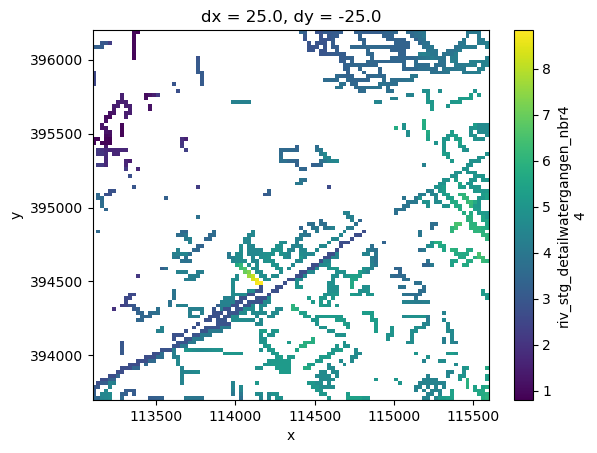

In [66]:
A.isel(x=slice(0,100), y=slice(0,100)).plot()